# Randon Forest Model wwith TF-IDF and Bag of words

In [2]:
# file path exist


import os.path
from os import path

# translator
import googletrans
from googletrans import Translator

# pandas
import pandas as pd

# preprocessing of text
import re
import string
import nltk
# word tokenizer by nltk
from nltk import word_tokenize

# lemmatizer
from nltk.stem import WordNetLemmatizer

# stopwords (Remove buzz words)
from nltk.corpus import stopwords

# split data into train and test
from sklearn.model_selection import train_test_split

# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

# RFM classifier from scikit learn
from sklearn.ensemble import RandomForestClassifier

# Tf-idf feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/syedshayanjamal/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# For English data
filename  = '../Data/Fake news detection/data'
df = pd.read_csv(filename + '.csv',  
               delimiter=',')
df.drop(df.columns[[0,1]], axis = 1, inplace = True)
df["Body"] = df["Body"].astype(str)
df["Label"] = df["Label"].astype(str)
data = df

In [4]:
# Same sentence after translation
data.Body[3]

'MEXICO CITY (Reuters) - Egypt’s Cheiron Holdings Limited won the rights to partner with Mexican national oil company Pemex on its onshore Cardenas-Mora project, the industry regulator said on Wednesday.\nThe tie-up marks only the second joint venture between the Pemex and a equity partner since an energy opening finalized in 2014 ended the company’s decades-long monopoly and allowed it to develop projects with private and foreign oil companies.\nCardenas-Mora is a 65-square-mile (168 sq km) field located in Tabasco state believed to contain 93 million barrels of oil equivalent (boe) in proven, probable and possible reserves.'

### Class count

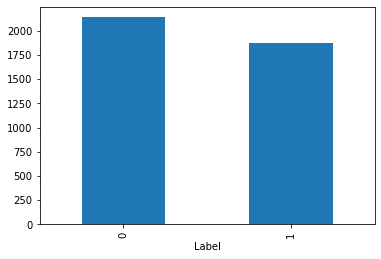

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
data.groupby('Label').Body.count().plot.bar(ylim=0)
plt.show()

In [6]:
# For entire dataset sentences for each labels 
data.Label.value_counts()

0    2137
1    1872
Name: Label, dtype: int64

In [7]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [8]:
new_text, new_label = balanceClasses(df['Body'], df['Label'])

In [9]:
data = pd.DataFrame(new_text)
data.columns = ['Body']
data['Label'] = new_label
data = pd.concat([df, data])

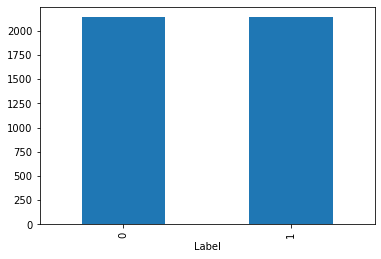

In [10]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Body.count().plot.bar(ylim=0)
plt.show()

In [11]:
data.Label.value_counts()

0    2137
1    2136
Name: Label, dtype: int64

In [12]:
data=data.sample(frac=1).reset_index(drop=True)
data

,Body,Label
0,There's a powerful hurricane creating so much ...,0
1,"By Catherine J. Frompovich\nOver a year ago, r...",0
2,(CNN) A former Disney Channel star has struck ...,1
3,Image copyright Reuters Image caption The firs...,1
4,Chat with us in Facebook Messenger. Find out w...,1
...,...,...
4268,One day after President Trump suggested that P...,1
4269,"TAMPA, Fla. (Reuters) - Defense Secretary Jim ...",1
4270,"(Reuters) - Shares of Switch Inc, which provid...",1
4271,Artificial intelligence (AI) has become a key ...,1


### Data Preprocessing

In [13]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Body'] = data['Body'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Body'] = data['Body'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Body'] = data['Body'].apply(lambda x: ReplaceFourColon(x))

In [14]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Body'] = data['Body'].apply(lambda x: textPattern(x))

In [15]:
data.shape

(4273, 2)

In [16]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Body]

In [17]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [18]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [19]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [20]:
# Removing Stopwords
stoplist = stopwords.words('english')

In [21]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [22]:
zero  = []
one = []

for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        
data['0']= zero
data['1']= one

data = data[['Text_Final', 'tokens', 'Label', '0', '1']]

In [23]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', 'Category_id' ]]
data.head(25)

,Text_Final,tokens,Label,0,1,Category_id
0,powerful hurricane creating much havoc united ...,"[powerful, hurricane, creating, much, havoc, u...",0,1,0,0
1,catherine j frompovich year ago reporter ruth ...,"[catherine, j, frompovich, year, ago, reporter...",0,1,0,0
2,( cnn ) former disney channel star ha struck b...,"[(, cnn, ), former, disney, channel, star, ha,...",1,0,1,1
3,image copyright reuters image caption first to...,"[image, copyright, reuters, image, caption, fi...",1,0,1,1
4,chat u facebook messenger find happening world...,"[chat, u, facebook, messenger, find, happening...",1,0,1,1
5,potato battery light room month diy ( system u...,"[potato, battery, light, room, month, diy, (, ...",0,1,0,0
6,embattled pharmaceutical company sell powerful...,"[embattled, pharmaceutical, company, sell, pow...",0,1,0,0
7,first significant basketball memory ? first on...,"[first, significant, basketball, memory, ?, fi...",1,0,1,1
8,time tomlin nip national anthem chaos bud sake...,"[time, tomlin, nip, national, anthem, chaos, b...",0,1,0,0
9,jet photo – jet 23 jaguar 20 % reader think st...,"[jet, photo, –, jet, 23, jaguar, 20, %, reader...",0,1,0,0


In [24]:
# Removing empty rows after tokenization

In [25]:
data = data[data.tokens != '']

In [26]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 10 % for testing. We use random state so every time we get the same training and testing data.

# RFM - TFIDF

In [27]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = vectorizer.fit_transform(data.Text_Final).toarray()
labels = data.Label
features.shape

(4273, 498253)

In [28]:
data.Label.value_counts()

0    2137
1    2136
Name: Label, dtype: int64

In [29]:
# Spliting data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features, labels, data.index, test_size=0.10,shuffle = True, random_state=42)

In [30]:
# Generate model
model1 = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=32)
clf = model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

### RFM - Displaying false-positive rate (FPR) and true positive rate (TPR)

Random Forest Method


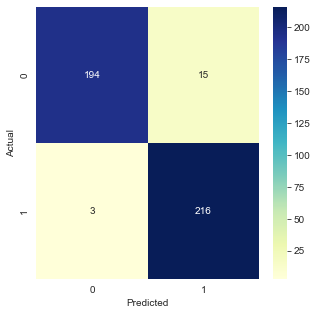

In [40]:
# confusion matrix
print("Random Forest Method")
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### RFM - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [41]:
results1 = confusion_matrix(y_test, y_pred)
print ('Confusion Matrix :')
print(results1) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print ('Report : ')
print (classification_report(y_test, y_pred))

Confusion Matrix :
[[194  15]
 [  3 216]]
Accuracy Score : 0.9579439252336449
Report : 
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       209
           1       0.94      0.99      0.96       219

    accuracy                           0.96       428
   macro avg       0.96      0.96      0.96       428
weighted avg       0.96      0.96      0.96       428



# RFM - BOW

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
features3 = count_vect.fit_transform(data.Text_Final).toarray()
labels = data.Label
features3.shape

(4273, 41427)

In [43]:
# Using similar split as CNN model
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features3, labels, data.index, test_size=0.10, shuffle = True, random_state=42)

In [44]:
# generate Linear SVM model
model3 = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=32)
clf3 = model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

###  RFM - BOW - Displaying false-positive rate (FPR) and true positive rate (TPR)

                     RFM - BOW


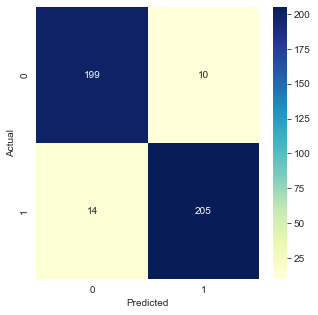

In [45]:
from sklearn.metrics import confusion_matrix
print("                     RFM - BOW")
conf_mat = confusion_matrix(y_test, y_pred3)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### RFM - BOW - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [46]:
results3 = confusion_matrix(y_test, y_pred3)
print ('Confusion Matrix :')
print(results3) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred3))
print ('Report : ')
print (classification_report(y_test, y_pred3))

Confusion Matrix :
[[199  10]
 [ 14 205]]
Accuracy Score : 0.9439252336448598
Report : 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       209
           1       0.95      0.94      0.94       219

    accuracy                           0.94       428
   macro avg       0.94      0.94      0.94       428
weighted avg       0.94      0.94      0.94       428



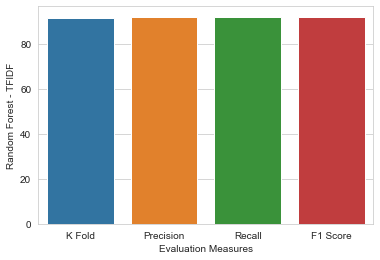

In [47]:
# for tfidf
import pandas as pd
import seaborn as sns
results=pd.DataFrame()
dictionary=dict()
dictionary['Evaluation Measures']=["K Fold", "Precision", "Recall", "F1 Score"]
dictionary['Random Forest - TFIDF']=[91.4, 92, 92, 92]
results=pd.DataFrame(dictionary)
sns.set_style(style="whitegrid")
ax = sns.barplot(x='Evaluation Measures', y= 'Random Forest - TFIDF',data=results)

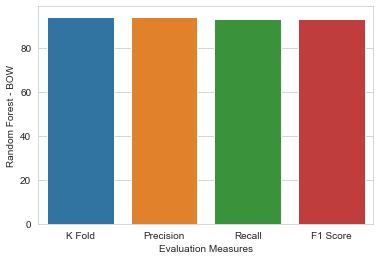

In [48]:
# for BOW
import seaborn as sns
results=pd.DataFrame()
dictionary=dict()
dictionary['Evaluation Measures']=["K Fold", "Precision", "Recall", "F1 Score"]
dictionary['Random Forest - BOW']=[94.1, 94, 93, 93]
results=pd.DataFrame(dictionary)
sns.set_style(style="whitegrid")
ax = sns.barplot(x='Evaluation Measures', y= 'Random Forest - BOW',data=results)